In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *
from analysis import *

import sys
sys.path.append(constants.GRANTHAM_DISTANCE_PATH)

import grantham_distance as gd

In [2]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
loaded = False

# Load BioBank Components

In [4]:
DEV_MODE = False
SIGNIFIER = ""

if not loaded:
    (biobank_data_no_HLA_alleles, biobank_index,
     med_code_mapping) = data_tools.load_all_biobank_components(DEV_MODE, signifier=SIGNIFIER)
    loaded = True
    HLA_alleles = data_tools.load_HLA_data()
    biobank_data = biobank_data_no_HLA_alleles.merge(HLA_alleles, how="left", on="eid")

Importing BioBank Index and Data:
Missing 0 biobank index names
Reduced feature set has 284 features.
UK BioBank Data Loaded.
Size: 502536 rows x 284 columns
Elapsed time: 39.6249 seconds


Mapping Medical Codes:   0%|          | 0/269 [00:00<?, ? feature/s]

In [229]:
biobank_data = biobank_data.replace('infectious mononucleosis / glandular fever / epstein barr virus (ebv)',
                                    "mononucleosis")
biobank_data = biobank_data.loc[~pd.isnull(biobank_data[constants.HLA_ALLELE_COLUMNS]).any(axis=1)]

In [182]:
def allele_counts(data: pd.DataFrame, allele: str):
    """"""
    allele_loc_cols = [f"{allele[0]}1", f"{allele[0]}2"]
    return np.sum(data[allele_loc_cols] == allele, axis=1)


def get_unique_alleles(data: pd.DataFrame, illness_values):
    """"""
    illness_alleles = data.loc[illness_values][constants.HLA_ALLELE_COLUMNS].values.ravel()
    return np.unique(illness_alleles[~pd.isnull(illness_alleles)])


def get_allele_associations(biobank_data, illness, feature, pbar: bool = False,
                            p_value_threshold: float = 0.05, n_threshold: int = 4):
    """"""

    illness_values = get_illness_value(biobank_data, illness, feature)
    illness_alleles = get_unique_alleles(biobank_data, illness_values)
    
    data = []
    illness_alleles = tqdm(illness_alleles) if pbar else illness_alleles
    for allele in illness_alleles:
        all_allele_zygosity = allele_counts(biobank_data, allele)

        data.append([allele, *calculate_OR(illness_values, all_allele_zygosity > 0), "het",
                     np.count_nonzero(all_allele_zygosity)])
        data.append([allele, *calculate_OR(illness_values, all_allele_zygosity > 1), "homo", 
                     np.count_nonzero(all_allele_zygosity > 1)])

    data = pd.DataFrame(data, columns=["allele", "odds_ratio", "p_value", "N", "lower_bound", "upper_bound",
                                       "zygosity", "N_allele"])
    data["illness"] = illness
    data["hla_loci"] = data["allele"].apply(lambda s: s[0])
    data["disease_frac"] = data["N"] / np.count_nonzero(illness_values)
    data["pop_frac"] = data["N_allele"] / len(biobank_data)
    data = data.drop(columns=["N_allele", "lower_bound", "upper_bound"])

    return data.query(f"p_value < {p_value_threshold} and N > {n_threshold}")

# Allele associating

In [183]:
search_data = data_tools.biobank_search(med_code_mapping, biobank_data, ('diabetes')).query("count > 0")
display(search_data)
print(search_data["meaning"].tolist()[:10])

,coding,meaning,code_format,name,count
97,1220,diabetes,6,illness_code,5874
100,1223,type 2 diabetes,6,illness_code,811
99,1222,type 1 diabetes,6,illness_code,176
98,1221,gestational diabetes,6,illness_code,103
320,1521,diabetes insipidus,6,illness_code,1


['diabetes', 'type 2 diabetes', 'type 1 diabetes', 'gestational diabetes', 'diabetes insipidus']


In [461]:
illnesses = [
    "multiple sclerosis",
#     'infectious mononucleosis / glandular fever / epstein barr virus (ebv)',
    "mononucleosis",
    "stomach cancer"
#     "hiv/aids",
#     "type 1 diabetes"
]

cancers = ['hodgkins lymphoma / hodgkins disease', "cervical cancer"]

cancers = ['hodgkins lymphoma / hodgkins disease',
 'larynx/throat cancer',
 'stomach cancer',
 'anal cancer',
 'liver/hepatocellular cancer',
 'cancer of lip/mouth/pharynx/oral cavity',
 'nasal cavity cancer',
 'kaposis sarcoma',
 'cervical cancer']
cancers_and_illnesses = cancers + illnesses

In [462]:
data = []
for illness in tqdm(cancers_and_illnesses):
    feature = "cancer_code" if illness in cancers else "illness_code"
    data.append(get_allele_associations(biobank_data, illness, feature, pbar=False))
    
data = pd.concat(data)

  0%|          | 0/12 [00:00<?, ?it/s]

In [463]:
illness_value_data = {}
for illness in tqdm(cancers_and_illnesses):
    feature = "cancer_code" if illness in cancers else "illness_code"
    illness_value_data[illness] = get_illness_value(biobank_data, illness, feature).values

  0%|          | 0/12 [00:00<?, ?it/s]

In [464]:
alleles_of_interest = ["A*02:01", "A*01:01"]
allele = alleles_of_interest[-1]

# data = biobank_data

all_allele_zygosity = allele_counts(biobank_data, allele)

for illness, illness_values in illness_value_data.items():
    print(illness, calculate_OR(illness_values, all_allele_zygosity > 1))

hodgkins lymphoma / hodgkins disease (1.8219489580243746, 0.0034458672141722702, 29, 1.3284155080309745, 2.4988401487170115)
larynx/throat cancer (0.9494533179597759, 1.0, 12, 0.5855417656934702, 1.5395342498194067)
stomach cancer (1.2736437193261705, 0.4212288755719716, 8, 0.702239351710783, 2.309993479896994)
anal cancer (0.8103998443260817, 1.0, 2, 0.24885789825775634, 2.6390478754405704)
liver/hepatocellular cancer (0.7597017836659191, 0.6909001175342229, 5, 0.3602659263419113, 1.6020021820143944)
cancer of lip/mouth/pharynx/oral cavity (1.3110641551152689, 0.44106336148920783, 5, 0.6171264293706031, 2.7853113025497547)
nasal cavity cancer (1.1886394776887474, 0.686981898607539, 2, 0.36207268635907447, 3.9021551780876784)
kaposis sarcoma (0.0, 1.0, 0, 0.0, nan)
cervical cancer (1.0596991144495322, 0.6252486209102599, 74, 0.8716335276493894, 1.2883421501620222)
multiple sclerosis (1.4947505342837235, 0.000418649943818163, 90, 1.2502653328215712, 1.7870439986520343)
mononucleosis (1.

In [476]:
het_data = data.query("zygosity == 'het'")
homo_data = data.query("zygosity == 'homo'")
het_data = het_data.loc[het_data.duplicated(["allele"], keep=False).values].sort_values("allele")
homo_data = homo_data.loc[homo_data.duplicated(["allele"], keep=False).values].sort_values("allele")

In [478]:
homo_data

,allele,odds_ratio,p_value,N,zygosity,illness,hla_loci,disease_frac,pop_frac
1,A*01:01,1.821949,3.445867e-03,29,homo,hodgkins lymphoma / hodgkins disease,A,0.063736,0.036044
1,A*01:01,1.494751,4.186499e-04,90,homo,multiple sclerosis,A,0.052848,0.036044
1,A*01:01,1.475659,4.304913e-02,30,homo,mononucleosis,A,0.052265,0.036044
5,A*02:01,0.767521,6.492414e-03,110,homo,cervical cancer,A,0.056643,0.072491
5,A*02:01,0.605042,4.252938e-06,77,homo,multiple sclerosis,A,0.045214,0.072491
127,B*44:02,2.629084,1.396498e-03,14,homo,hodgkins lymphoma / hodgkins disease,B,0.030769,0.011948
155,B*44:02,0.389454,3.381989e-03,8,homo,multiple sclerosis,B,0.004698,0.011948
203,C*03:03,1.911347,4.695291e-02,10,homo,multiple sclerosis,C,0.005872,0.003091
149,C*03:03,2.840621,3.422193e-02,5,homo,mononucleosis,C,0.008711,0.003091
155,C*07:02,1.790484,3.519386e-02,15,homo,larynx/throat cancer,C,0.042857,0.024411


In [466]:
het_data = het_data.loc[het_data.duplicated(["allele"], keep=False).values].sort_values("allele")
het_data

,allele,odds_ratio,p_value,N,zygosity,illness,hla_loci,disease_frac,pop_frac
2,A*02:01,0.765187,1.661717e-03,226,het,mononucleosis,A,0.393728,0.459007
4,A*02:01,0.672124,1.382886e-15,619,het,multiple sclerosis,A,0.363476,0.459007
40,A*31:01,1.485639,1.779542e-02,43,het,mononucleosis,A,0.074913,0.051718
48,A*31:01,1.273555,1.022257e-02,126,het,cervical cancer,A,0.064882,0.051718
70,B*07:02,1.600234,1.115710e-19,620,het,multiple sclerosis,B,0.364063,0.263838
74,B*07:02,1.218618,7.838020e-05,590,het,cervical cancer,B,0.303811,0.263838
48,B*08:01,1.471598,1.920489e-02,59,het,stomach cancer,B,0.335227,0.255245
48,B*08:01,1.471598,1.920489e-02,59,het,stomach cancer,B,0.335227,0.255245
38,B*08:01,0.445050,1.786974e-02,9,het,anal cancer,B,0.132353,0.255245
76,B*13:02,0.692474,1.040103e-02,47,het,multiple sclerosis,B,0.027598,0.039331


(-5, 5)

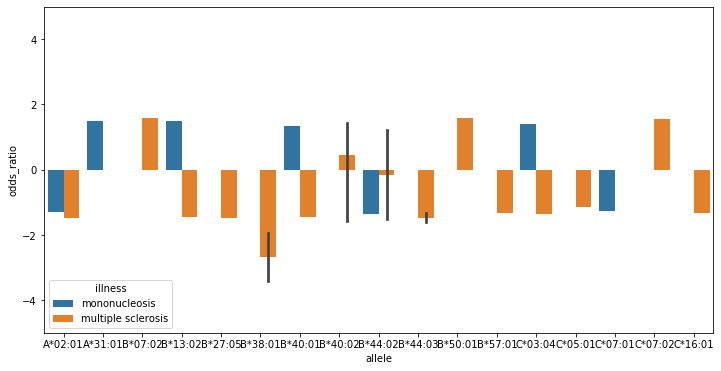

In [467]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=het_data.loc[het_data["illness"].isin(["multiple sclerosis", "mononucleosis"])], x="allele",
            y=het_data["odds_ratio"].apply(lambda s: s if s > 1 else -1 / s), hue="illness", ax=ax, dodge=True)
ax.set_ylim(-5, 5)

In [468]:
data.query("illness == 'hodgkins lymphoma / hodgkins disease' and zygosity == 'homo'")

,allele,odds_ratio,p_value,N,zygosity,illness,hla_loci,disease_frac,pop_frac
1,A*01:01,1.821949,0.003446,29,homo,hodgkins lymphoma / hodgkins disease,A,0.063736,0.036044
127,B*44:02,2.629084,0.001396,14,homo,hodgkins lymphoma / hodgkins disease,B,0.030769,0.011948


In [469]:
data.query("illness == 'cervical cancer'")

,allele,odds_ratio,p_value,N,zygosity,illness,hla_loci,disease_frac,pop_frac
5,A*02:01,0.767521,0.006492,110,homo,cervical cancer,A,0.056643,0.072491
48,A*31:01,1.273555,0.010223,126,het,cervical cancer,A,0.064882,0.051718
74,B*07:02,1.218618,0.000078,590,het,cervical cancer,B,0.303811,0.263838
88,B*15:01,0.785688,0.001507,185,het,cervical cancer,B,0.095263,0.118085
116,B*35:01,0.840134,0.034166,160,het,cervical cancer,B,0.082389,0.096497
130,B*38:01,0.516246,0.001778,20,het,cervical cancer,B,0.010299,0.019721
154,B*44:02,1.216263,0.000345,454,het,cervical cancer,B,0.233780,0.200680
184,B*55:01,1.411505,0.001694,96,het,cervical cancer,B,0.049434,0.035589
214,C*04:01,0.844572,0.008292,285,het,cervical cancer,C,0.146756,0.169105
215,C*04:01,0.466652,0.026870,8,homo,cervical cancer,C,0.004119,0.008768


In [470]:
data.query("illness == 'mononucleosis'")

,allele,odds_ratio,p_value,N,zygosity,illness,hla_loci,disease_frac,pop_frac
1,A*01:01,1.475659,0.043049,30,homo,mononucleosis,A,0.052265,0.036044
2,A*02:01,0.765187,0.001662,226,het,mononucleosis,A,0.393728,0.459007
40,A*31:01,1.485639,0.017795,43,het,mononucleosis,A,0.074913,0.051718
64,B*13:02,1.490734,0.031013,33,het,mononucleosis,B,0.057491,0.039331
71,B*15:01,2.604495,0.030842,6,homo,mononucleosis,B,0.010453,0.004047
102,B*40:01,1.344708,0.019398,77,het,mononucleosis,B,0.134146,0.103348
110,B*44:02,0.740413,0.007792,90,het,mononucleosis,B,0.156794,0.200680
149,C*03:03,2.840621,0.034222,5,homo,mononucleosis,C,0.008711,0.003091
150,C*03:04,1.405768,0.001739,112,het,mononucleosis,C,0.195122,0.147141
156,C*06:02,1.288766,0.015062,122,het,mononucleosis,C,0.212544,0.173213


In [472]:
data.loc[data["allele"].isin(["A*01:01", "B*44:02"])].sort_values(["allele", "illness"]).reset_index(drop=True)

,allele,odds_ratio,p_value,N,zygosity,illness,hla_loci,disease_frac,pop_frac
0,A*01:01,1.821949,3.445867e-03,29,homo,hodgkins lymphoma / hodgkins disease,A,0.063736,0.036044
1,A*01:01,1.475659,4.304913e-02,30,homo,mononucleosis,A,0.052265,0.036044
2,A*01:01,1.164462,2.683448e-03,636,het,multiple sclerosis,A,0.373459,0.338693
3,A*01:01,1.494751,4.186499e-04,90,homo,multiple sclerosis,A,0.052848,0.036044
4,B*44:02,1.216263,3.445690e-04,454,het,cervical cancer,B,0.233780,0.200680
5,B*44:02,2.629084,1.396498e-03,14,homo,hodgkins lymphoma / hodgkins disease,B,0.030769,0.011948
6,B*44:02,0.740413,7.792087e-03,90,het,mononucleosis,B,0.156794,0.200680
7,B*44:02,0.662096,5.717538e-10,243,het,multiple sclerosis,B,0.142689,0.200680
8,B*44:02,0.389454,3.381989e-03,8,homo,multiple sclerosis,B,0.004698,0.011948


In [475]:
data.loc[data["allele"].isin(["C*07:01", "C*07:02"])].sort_values(["allele", "illness"]).reset_index(drop=True)

,allele,odds_ratio,p_value,N,zygosity,illness,hla_loci,disease_frac,pop_frac
0,C*07:01,0.516484,3.554638e-02,13,het,anal cancer,C,0.191176,0.313942
1,C*07:01,0.793977,1.502478e-02,153,het,mononucleosis,C,0.266551,0.313942
2,C*07:01,1.621068,8.104842e-05,81,homo,multiple sclerosis,C,0.047563,0.029947
3,C*07:01,1.443325,1.843906e-02,70,het,stomach cancer,C,0.397727,0.313942
4,C*07:01,1.443325,1.843906e-02,70,het,stomach cancer,C,0.397727,0.313942
5,C*07:02,1.185056,5.547149e-04,622,het,cervical cancer,C,0.320288,0.284645
6,C*07:02,1.790484,3.519386e-02,15,homo,larynx/throat cancer,C,0.042857,0.024411
7,C*07:02,1.553919,5.538207e-18,650,het,multiple sclerosis,C,0.381679,0.284645
8,C*07:02,2.054949,9.013404e-09,83,homo,multiple sclerosis,C,0.048738,0.024411


# Logistic Regression Attempts

In [230]:
all_alleles = sorted(np.unique(biobank_data[constants.HLA_ALLELE_COLUMNS].values))

In [396]:
all_alleles = sorted(data["allele"].unique())
# all_alleles = ["A*01:01", "A*02:01"]

In [397]:
X_full = []
for allele in tqdm(all_alleles):
    X_full.append((biobank_data[constants.HLA_ALLELE_COLUMNS] == allele).sum(axis=1).values)
X_full = np.array(X_full).T

  0%|          | 0/50 [00:00<?, ?it/s]

In [382]:
y_full = []
for illness in tqdm(cancers_and_illnesses):
    feature = "cancer_code" if illness in cancers else "illness_code"
    y_full.append(get_illness_value(biobank_data, illness, feature).values * 1)
y_full = np.array(y_full).T
y_full = y_full[:, -1]

  0%|          | 0/4 [00:00<?, ?it/s]

In [408]:
X_control = X_full[~y_full]
n_disease = np.count_nonzero(y_full)
indices = np.random.choice(np.arange(len(X_control)), n_disease)

X = np.vstack([X_control[indices], X_full[y_full == 1]])
y = np.array([0] * n_disease + [1] * n_disease)
X = (X > 0) * 1

In [409]:
from sklearn.linear_model import LogisticRegression as LR

clf = LR(random_state=0, penalty="l1", solver="saga", warm_start=True).fit(X, y)

C:\Users\Cole\Miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [410]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [411]:
clf.score(X, y)

0.9991289198606271

In [412]:
for allele, OR in zip(all_alleles, np.exp(clf.coef_).ravel()):
    if OR != 1:
        print(allele, OR)

A*01:01 1.0795385638827473
B*35:01 0.04042820740800643
C*06:02 0.1087154958849661
C*17:01 0.00018207682224156163
